# IVADO/MILA DEEP LEARNING SCHOOL
# Spring 2021
# Tutorial : Categorical data with multilayer perceptron (MLP)

## Authors: 

Arsène Fansi Tchango <arsene.fansi.tchango@mila.quebec>

Gaétan Marceau Caron <gaetan.marceau.caron@mila.quebec>

# Preface

This tutorial introduces the practical aspects of Deep Learning through the realization of a simple end-to-end project. We will use the deep learning library <a href="https://pytorch.org/"> `PyTorch`</a>, which is well-known for its ease of use.

# Initialization

Before we begin, we must install all the required libraries for this part of the tutorial. To do so, we will use the `pip` utility. Execute the cell below by selecting it and pressing `shift`+`Enter`. (This operation may take a few minutes.)

We need to be using the latest version of `pillow` for this tutorial. If you are prompted with:

> WARNING: The following packages were previously imported in this runtime:
  [PIL]
You must restart the runtime in order to use newly installed versions.

Then click on restart runtime and rerun the cells afterwards.

In [ ]:
!pip3 install torch torchvision matplotlib
!pip3 install --upgrade pillow==8.1.0

Requirement already up-to-date: pillow==8.1.0 in /usr/local/lib/python3.6/dist-packages (8.1.0)


To ensure that all required libraries are available, let's try to load all libraries and modules we will need during this tutorial by executing this cell: 

In [ ]:
import importlib
required_libraries = ['torch', 'torchvision', 'PIL', 'matplotlib']
for lib in required_libraries:
    if importlib.util.find_spec(lib) is None:
        print("%s unavailable" % lib)

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.utils.data import TensorDataset

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

print("Torch version: ", torch.__version__)
print("GPU Available: {}".format(use_gpu))

Torch version:  1.7.0+cu101
GPU Available: True


Fix the seed for the different libraries

In [ ]:
seed = 1234
np.random.seed(seed) # Set the random seed of numpy for the data split.
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# PyTorch in a nutshell

*PyTorch* is a Python library that supports a vibrant ecosystem of tools and libraries for machine learning (ML) in vision, NLP, and more. It provides two high-level features:
<ul>
<li> operations on <a href="https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py">tensors</a> (such as NumPy) with GPU support,</li>
<li> operations for creating and optimizing computational graphs with an automatic differentiation system called <a href="https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py">Autograd</a>.</li>
</ul>

<a href="https://pytorch.org/docs/stable/torch.html">PyTorch docs</a> contain the API documentation and <a href="https://pytorch.org/tutorials/">many tutorials</a>.
Also, PyTorch offers several data processing utilities. One of these utilities is the class <a href="http://pytorch.org/docs/master/data.html#"> `torch.utils.data.Dataset`</a> which offers an easy to use interface to handle a data set. For more information, please refer to the following urls: 
<ul>
<li>PyTorch data sets: <a href="http://pytorch.org/docs/master/data.html"> PyTorch - datasets</a>.</li>
<li>A tutorial for loading data: <a href="http://pytorch.org/tutorials/beginner/data_loading_tutorial.html"> PyTorch - data loading tutorial</a>.</li>
</ul>

<a href="http://pytorch.org/docs/master/cuda.html#module-torch.cuda">`torch.cuda`</a> is a package that provides the same functions as CPU tensors but for  CUDA tensors, which are used for GPU computing. <a href="http://pytorch.org/docs/master/cuda.html#torch.cuda.is_available">`torch.cuda.is_available()`</a> returns a boolean indicating if CUDA is currently available. Finally, we recommend using a `device` variable that identifies the device that will perform computations. We can assign a tensor to a device with the method `.to(device)`. By default, the tensors are CPU tensors.

# Ingredients for a proof of concept (POC)

To realize a ML POC, you need:
<ul>
<li>a task description as well as data to support it,</li>
<li>evaluation metrics to assess the performance of models,</li>
<li>a model description,</li>
<li>a loss function to minimize,</li>
<li>an optimizer that adjusts the parameters of the model.</li>
</ul>

# How to prepare the dataset?

In this tutorial, we study the tragedy of the Titanic through a data-driven approach. Our task is to determine whether or not a passenger survived the Titanic sinking based on passenger data only. The results will show how the passengers' fate was pre-determined by the features selected in this study, without considering other factors.

## Titanic dataset

First, we download the Titanic dataset from the following address:
<br/>
https://github.com/afansi/winterschool18/blob/master/titanic3.csv?raw=true.<br/>
This dataset provides information on the fate of 1309 passengers of the first and only journey of the liner RMS Titanic, summarized by economic status (class), gender, age, family information, and survival. We use this dataset because we can train models very quickly for the purpose of this tutorial. The Kaggle platform also uses this dataset as an introduction to classical machine learning. <br/>

Let's take a look at the features and some examples from this dataset. To do so, we use the library <a href="https://pandas.pydata.org/">Pandas</a> to load the dataset into memory.

In [ ]:
titanic_df = pd.read_csv(
    'https://github.com/afansi/winterschool18/blob/master/titanic3.csv?raw=true', 
    sep='\t', 
    index_col=None, 
    na_values=['NA']
)

# a snapshot of the first 5 data points
titanic_df.head()



,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


Here's the list of the features with their description:

<ol>

  <li> <b>pclass</b>: Passenger class (1 = first; 2 = second; 3 = third) </li>
  <li> <b>survived</b>: Survived? (0 = no; 1 = yes) </li>
  <li> <b>name</b>: Name </li>
  <li> <b>sex</b>: Sex </li>
  <li> <b>age</b>: Age </li>
  <li> <b>sibsp</b>: Number of brothers, sisters, or spouses onboard </li>
  <li> <b>parch</b>: Number of parents or children onboard </li>
  <li> <b>ticket</b>: Ticket number </li>
  <li> <b>fare</b>: Passenger fare </li>
  <li> <b>cabin</b>: Cabin number </li>
  <li> <b>embarked</b>: Port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton) </li>
  <li> <b>boat</b>: Lifeboat (if the passenger survived) </li>
  <li> <b>body</b>: Body number (if the passenger did not survive and his body was found) </li>
  <li> <b>home.dest</b>: the passenger's destination </li>
 </ol>


## Data pre-processing

### Feature selection
Some features are not relevant to the task, for example:
<ol>
  <li> <b>name</b>: Name </li>
  <li> <b>ticket</b>: Ticket number </li>
  <li> <b>cabin</b>: Cabin number </li>
  <li> <b>home.dest</b>: Passenger's destination </li>
 </ol>
 
Other features are directly related to the passenger survival and are not interesting for our study because they give away the label to be predicted:
<ol>
  <li> <b>boat</b>: Lifeboat (if the passenger survived) </li>
  <li> <b>body</b>: Body number (if the passenger did not survive and his body was found) </li>
 </ol>

In [ ]:
titanic_preprocess_df = pd.read_csv(
    'https://github.com/afansi/winterschool18/blob/master/titanic_prepocess.csv?raw=true', 
    sep=',', 
    index_col=None
)

titanic_preprocess_df.head()

,survived,pclass_1,pclass_2,pclass_3,sex_female,sex_male,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
0,1,1,0,0,1,0,29.0000,0,0,211.3375,0,0,1
1,1,1,0,0,0,1,0.9167,1,2,151.5500,0,0,1
2,0,1,0,0,1,0,2.0000,1,2,151.5500,0,0,1
3,0,1,0,0,0,1,30.0000,1,2,151.5500,0,0,1
4,0,1,0,0,1,0,25.0000,1,2,151.5500,0,0,1


### Feature encoding
 
Some features are **categorical variables**, which means that they can take a finite number of values.
 <ol>
  <li> <b>pclass</b>: Passenger Class </li>
  <li> <b>sex</b>: Sex </li>
  <li> <b>embarked</b>: Port of embarkation </li>
 </ol>

To process categorical variables, we need to encode them in a way that does not imply an arbitrary order such as using natural numbers (e.g., 1, 2, 3). <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html">One-hot encoding</a> is a way to achieve it. <br/> We can download the pre-processed dataset at the following address: 
<br/>
https://github.com/afansi/winterschool18/blob/master/titanic_prepocess.csv?raw=true.
<br/>The meaning of the encoded variables is as follows:

<ol>
  <li> <b>survived</b>: Survived? (0 = no; 1 = yes) </li>
  <li> <b>pclass_1</b>: (1 if passenger in first class; 0 if not) </li>
  <li> <b>pclass_2</b>: (1 if passenger in second class; 0 if not) </li>
  <li> <b>pclass_3</b>: (1 if passenger in third class; 0 if not) </li>
  <li> <b>sex_female</b>: (1 if passenger is female; 0 if not) </li>
  <li> <b>sex_male</b>: (1 if passenger is male; 0 if not) </li>
  <li> <b>age</b>: Age </li>
  <li> <b>sibsp</b>: Number of brothers, sisters, or spouses onboard </li>
  <li> <b>parch</b>: Number of parents or children onboard </li>
  <li> <b>fare</b>: Passenger fare </li>
  <li> <b>embarked_C</b>: (1 if Port of embarkation = Cherbourg (C); 0 otherwise) </li> 
  <li> <b>embarked_Q</b>: (1 if Port of embarkation = Queenstown (Q); 0 otherwise) </li> 
  <li> <b>embarked_S</b>: (1 if Port of embarkation = Southampton (S); 0 otherwise)</li> 
 </ol>

## Train / validation / test split

At this point, we need to divide the dataset into three subsets:

<ol>
<li> <b> Train</b> (usually 60% of the dataset): used to train the classification model. </li>   
<li> <b> Validation</b> (generally 20% of the dataset): used to evaluate hyper-parameters on held-out data. </li>   
<li> <b> Test</b> (usually 20% of the dataset): used to evaluate the generalization performance of the chosen model on held-out data. </li>
</ol>

We use the <a href="https://numpy.org/doc/stable/reference/generated/numpy.split.html">numpy.split function</a> to separate our dataset into subsets.

### Exercise 1
Complete the missing code to create the validation and the test set

In [ ]:
train, validate, test = np.split(
    titanic_preprocess_df.sample(frac=1, random_state=seed), 
    [int(.6*len(titanic_preprocess_df)), int(.8*len(titanic_preprocess_df))])

# Remove the label column from X and create a label vectors.
X_train = train.drop(['survived'], axis=1).values
y_train = train['survived'].values

X_val = ... # To complete.
y_val = ... # To complete.

X_test = ... # To complete.
y_test = ... # To complete.


## Datasets in PyTorch

We will use the subclass <b><a href="https://pytorch.org/docs/master/data.html#torch.utils.data.TensorDataset"> `torch.utils.data.TensorDataset`</a> </b> to manipulate together the features and targets of a dataset.

### Exercise 2

Complete the missing code to load the validation and the test sets in TensorDatasets.

In [ ]:
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ... # To complete.
test_dataset = ... # To complete.


# How to define the learning algorithm?

To train a deep learning model, we need to define:
<ul>
<li>the network architecture by choosing the non-linear function and the number of hidden units per layer, </li>
<li>the loss function and optimizer. </li>
</ul>

In this tutorial, we consider the multilayer perceptron (MLP). A MLP is a simple computational graph composed of "hidden layers," which are defined by two modules: a *linear transformation* followed by a *non-linearity*. The result of a hidden layer is a vector called *a distributed representation* where each component is associated with a hidden unit.

To solve our task, we will use a MLP with the following architecture:
 <ul>
 <li> the input dimension of the model is 12,</li>
 <li> the output dimension of the model is 2,</li>
 <li> the first dimension of the output is the probability of death and the second dimension is the probability of survival,</li>
  <li> the number of hidden layers is 3, </li>
 <li> the dimensions of the hidden layers are 20, 40, 20 respectively, </li>
 <li> the activation function is a ReLu for all hidden layers. </li>
 </ul>

## How to define a model in PyTorch?

The <a href="https://pytorch.org/docs/stable/nn.html">PyTorch NN package</a> contains many useful classes for creating computation graphs.
<ul>
<li> The class <a href="https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module">torch.nn.Module</a>: 
any new module must inherit from this class or its descendants (subclasses).
</li>   
<li> The `forward` method:  any class defining a module must implement the `forward(...)` method, which defines the transformation of inputs to outputs.</li>  
<li> The class <a href="https://pytorch.org/docs/master/generated/torch.nn.Linear.html#torch.nn.Linear">`torch.nn.Linear(in_features, out_features)`</a>: this class implements a linear transformation. By default, it takes two parameters: 
    <ul>
    <li>`in_features`: the size of the data at the input of the module. </li>
    <li>`out_features`: the size of the data at the output of the module. </li>
    </ul>
</li>
<li> The module <a href="https://pytorch.org/docs/master/nn.functional.html#torch-nn-functional">`torch.nn.functional`</a>: 
it defines a set of functions that can be applied directly to any tensor. As examples, we have:
    <ul>
    <li> non-linear functions: sigmoid(...), tanh(...), relu(...), etc...</li> 
    <li> loss functions: mse_loss(...), nll(...., cross_entropy(...), etc ... </li> 
    <li> regularization functions: droupout(...), etc ... </li> 
    </ul>
</li>
</ul>

### Exercise 3

Complete the following methods to define a neural network:
<ul>
<li>The `__init__` method that defines the layers. </li>
<li>The `forward(input)` method that returns the `output`. </li>
</ul>

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self):
      ... # To complete.

    def forward(self, x):      
      ... # To complete.
      return out

## Making predictions with a neural network

Now, we are ready to test our neural network on randomly selected data.

In PyTorch, a model has two different modes:
    <ul>
    <li> <b>train</b>: used during training, </li>
    <li> <b>eval</b>: used during inference for model evaluation. </li>
    </ul>

The distinction is important since some modules behave differently according to this mode.
We will use the <b>eval</b> mode in this section.

### Exercise 4
Complete the missing code so that the model outputs a probability vector. 

In [ ]:
# Model definition
neural_net = NeuralNet()
neural_net = neural_net.to(device)

# Evaluation mode activation
neural_net = neural_net.eval()

# Select the first 5 data points
data, target = val_dataset[0:5]
data = data.to(device)
target = target.to(device)

# Forward propagation of the data through the model
output = neural_net(data)   # equivalent to neural_net.forward(data)

# Convert the logits into probabilities with softmax function
output_proba = ... # To complete.

# Printing the probability
print(output_proba)

tensor([[0.5093, 0.4907],
        [0.5069, 0.4931],
        [0.5129, 0.4871],
        [0.5022, 0.4978],
        [0.4427, 0.5573]], device='cuda:0', grad_fn=<SoftmaxBackward>)


The rows define the output of the network, in terms of probabilities over two classes: <b>deceased</b> (first column) or <b>survived</b> (second column), for each of the five input data points. Let us take the label with maximum probability as the predicted label and compare it to the correct label.

In [ ]:
# Printing predictions (class with the highest probability)
_, prediction = torch.max(output_proba, dim=1)

print('Model prediction')
print(prediction)

# Printing the real labels
print("Actual data")
print(target)

Model prediction
tensor([0, 0, 0, 0, 1], device='cuda:0')
Actual data
tensor([0, 0, 0, 0, 0], device='cuda:0')


### Exercise 5

1.   What would be a good way to measure the model performances?
2.   How does our model perform?
3.   Considering that the model is not trained on the dataset, do you see any problem with your selected measure?


... # To complete.



## Define the loss function and optimizer

### Loss function

We define the loss function according to the task we want to achieve.

PyTorch offers <a href="https://pytorch.org/docs/stable/nn.html#loss-functions">many ready-to-use loss functions</a>.

For classification problems, the usual loss function is <b>cross-entropy</b>, and this is the one we will use in this tutorial. In PyTorch, it is defined by the function <a href="https://pytorch.org/docs/master/nn.functional.html#cross-entropy">`torch.nn.functional.cross_entropy`</a>.  Cross entropy allows comparing a $p$ distribution with a reference distribution $t$. It attains its minimum when $t=p$. Its formula for calculating it between the prediction and the target is: $-\sum_j t_{ij} \log(p_{ij})$ where $p$ is the prediction, $t$ the target, $i$ the examples and $j$ the classes of the target.

In [ ]:
def loss_function(prediction, target):
    loss = F.cross_entropy(prediction, target)
    return loss

### Backpropagation

In Pytorch, thanks to the automatic differentiation mechanism <a href="http://pytorch.org/docs/master/notes/autograd.html">Autograd</a>, it is possible to automatically calculate the gradient of the loss function and backpropagate it through the computational graph.

To do this, we only have to call the method `backward()` on the variable returned by the loss function, e.g., with

`loss = loss_function(....)` <br>
`loss.backward()`

### Optimization

PyTorch provides a <a href="http://pytorch.org/docs/master/optim.html#algorithms">set of optimization methods (`torch.optim`)</a> commonly used by the deep learning community. These methods include the following: 
<ul>
<li><b>SGD</b> (Stochastic Gradient Descent) <a href="http://pytorch.org/docs/master/optim.html#torch.optim.SGD">`torch.optim.SGD(net.parameters(), lr=learning_rate)`</a></li>
<li><b>Adam</b> (Adaptive Moment Estimation): a variant of the gradient descent method in which the learning rate is adjusted for each parameter by estimating the first and second moments of the gradients. This optimizer has demonstrated excellent performance compared to SGD on many benchmarks. </li>
</ul>

To be able to use an optimizer in PyTorch, we must instantiate it by passing the following elements:
<ul>
<li><b>The parameters of the model</b>: these are obtained using the method <b>parameters()</b> on the instantiated model. </li>
<li><b>The learning rate (lr)</b>: this is the learning rate to be used to update parameters during the optimization process. </li>
<li>There may be other parameters specific to the chosen optimizer.</li>
</ul>

PyTorch offers a simplified interface to interact with any optimizer:
<ul>
<li><b>zero_grad()</b>: Allows to reinitialize the gradients to zero at the beginning of an optimization step.</li>
<li><b>step()</b>: Allows to perform an optimization step after a gradient backpropagation step.</li>
</ul>

We will use Adam with a lr of 0.001.

In [ ]:
optimizer = optim.Adam(neural_net.parameters(), lr=0.001) 

# How to train and evaluate a model?
First, we need some definitions:
<ol>
<li>
<b>Epoch</b>: a complete pass over the entire training dataset.
</li>
<li>
<b>Iteration</b>: an update of the model parameters. Many iterations can occur before the end of an epoch.
</li>
<li>
<b>Mini-batch</b>: A subset of training data used to estimate the average of gradients. In other words, at each iteration, a mini-batch is used. 
</li>
</ol>

## Creating the mini-batches
PyTorch offers a utility called <b><a href="http://pytorch.org/docs/master/data.html"> torch.utils.data.DataLoader </a></b> to load any dataset and automatically split it into mini-batches. During training, the data presented to the network should appear in a different order from one epoch to another. We will prepare the `DataLoader` for our three datasets (training, validation, and test).

In [ ]:
train_batch_size = 32  # number of data in a training batch.
eval_batch_size = 32   # number of data in an batch.


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=eval_batch_size, shuffle=False)

## Simple training loop

Here we define our training procedure for an epoch.

In [ ]:
def train(epoch, model, train_loader, optimizer, device):
    
    # activate the training mode
    model.train()
    
    torch.set_grad_enabled(True)
    
    total_loss = 0
    correct = 0
    
    # iteration over the mini-batches
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # transfer the data on the chosen device
        data, target = data.to(device), target.to(device)
        
        # reinitialize the gradients to zero
        optimizer.zero_grad()
        
        # forward propagation on the data
        prediction = model(data)
        
        # compute the loss function w.r.t. the targets
        loss = loss_function(prediction, target)
        
        # execute the backpropagation
        loss.backward()
        
        # execute an optimization step
        optimizer.step()
        
        # accumulate the loss
        total_loss += loss.item()*len(data)
        
        # compute the number of correct predictions
        _, pred_classes = torch.max(prediction, dim=1)        
        correct += pred_classes.eq(target.view_as(pred_classes)).sum().item()
         
        
    # compute the average loss per epoch
    mean_loss = total_loss/len(train_loader.dataset)
    
    # compute the accuracy
    acc = correct / len(train_loader.dataset)
        
    print('Train Epoch: {}   Avg_Loss: {:.5f}   Acc: {}/{} ({:.3f}%)'.format(
        epoch, mean_loss, correct, len(train_loader.dataset),
        100. * acc))   
    
    # return the average loss and the accuracy
    return mean_loss, acc

## Evaluation procedure
Here we define our model evaluation procedure.
<br/>
In addition to switching the model to **eval** mode, it is essential to disable the gradient calculation. 
<br/>
To do this, PyTorch offers a set of context managers to <a href="https://pytorch.org/docs/0.4.0/torch.html#locally-disabling-gradient-computation">locally disable/enable gradient calculation </a>:
<ol>
<li>
`torch.no_grad()`: disable gradient calculation.
</li>
<li>
`torch.enable_grad()`: enable gradient calculation.
</li>
<li>
`torch.set_grad_enabled(bool)`: enable/disable gradient calculation.
</li>
</ol>



In [ ]:
def evaluate(model, eval_loader, device):
    
    # activate the evaluation mode
    model.eval()
    
    total_loss = 0
    correct = 0
    
    with torch.no_grad():
    
        # iterate over the batches
        for batch_idx, (data, target) in enumerate(eval_loader):

            # transfer the data on the chosen device
            data, target = data.to(device), target.to(device)

            # forward propagation on the data
            prediction = model(data)

            # compute the loss function w.r.t. the targets
            loss = loss_function(prediction, target)           


            # accumulate the loss
            total_loss += loss.item()*len(data)

            # compute the number of correct predictions en sortie)
            _, pred_classes = torch.max(prediction, dim=1) 
            correct += pred_classes.eq(target.view_as(pred_classes)).sum().item()         
          
    
    # compute the average loss per epoch
    mean_loss = total_loss/len(eval_loader.dataset)
    
    # compute the accuracy
    acc = correct / len(eval_loader.dataset)
        
    print('Eval:  Avg_Loss: {:.5f}   Acc: {}/{} ({:.3f}%)'.format(
        mean_loss, correct, len(eval_loader.dataset),
        100. * acc)) 
    
    # return the average loss and the accuracy
    return mean_loss, acc

## Checkpointing

During training, we recommend saving the model parameters periodically. By doing so, we avoid having to retrain the model from scratch if the experiment goes wrong such as losing communication with GPU, out-of-memory error, numerical errors, incorrect learning rates making the experiment unstable, etc. This practice is commonly referred to as <b>checkpointing</b>.

PyTorch offers <a href="http://pytorch.org/docs/master/notes/serialization.html">a simple mechanism</a> to perform this operation.

We implement two methods here:
<ul>
<li> the first one for <b> saving </b> a model,</li>
<li> the second for <b> loading </b> a model checkpoint. </li>
</ul>

In [ ]:
def save_model(epoch, model, path='./'):
    
    # creating the file name indexed by the epoch value
    filename = path + 'neural_network_{}.pt'.format(epoch)
    
    # saving the model parameters
    torch.save(model.state_dict(), filename)
    
    return model
    

In [ ]:
def load_model(epoch, model, path='./'):
    
    # creating the file name indexed by the epoch value
    filename = path + 'neural_network_{}.pt'.format(epoch)
    
    # loading the parameters of the saved model
    model.load_state_dict(torch.load(filename))
    
    return model

It is also possible to save the optimizer's status in PyTorch, which is very important when we want to resume training the model from a given backup. For more information, please consult <a href='https://discuss.pytorch.org/t/saving-and-loading-a-model-in-pytorch/2610/3'>the following URL</a>.

## Putting everything together

In [ ]:
# maximum number of epoch
numEpochs = 200

# Saving frequency
checkpoint_freq = 10

# Directory for data backup
path = './'

# Accumulators of average losses obtained per epoch
train_losses = []
val_losses = []

# Performance accumulators per epoch
train_accuracies = []
val_accuracies = []

# Model definition
neural_net = NeuralNet()

# Load the model on the chosen device
neural_net = neural_net.to(device)

# Optimizer definition
optimizer = optim.Adam(neural_net.parameters(), lr=0.001) 
# optimizer = optim.SGD(neural_net.parameters(), lr=0.001) 


# Learning loop
for epoch in range(1, numEpochs + 1):
    
    # train the model with the train dataset
    train_loss, train_acc = train(epoch, neural_net, train_loader, optimizer, device)   
    
    # evaluate the model with the validation dataset
    val_loss, val_acc = evaluate(neural_net, val_loader, device)       
    
    # Save the losses obtained
    train_losses.append(train_loss)    
    val_losses.append(val_loss)
    
    # Save the performances
    train_accuracies.append(train_acc)    
    val_accuracies.append(val_acc)
    
    # Checkpoint
    if epoch % checkpoint_freq ==0:
        save_model(epoch, neural_net, path)

# Save the model at the end of the training
save_model(numEpochs, neural_net, path)
    
print("\n\n\nOptimization ended.\n")    


Train Epoch: 1   Avg_Loss: 0.81900   Acc: 278/625 (44.480%)
Eval:  Avg_Loss: 0.69177   Acc: 103/209 (49.282%)
Train Epoch: 2   Avg_Loss: 0.65573   Acc: 405/625 (64.800%)
Eval:  Avg_Loss: 0.64622   Acc: 143/209 (68.421%)
Train Epoch: 3   Avg_Loss: 0.62872   Acc: 423/625 (67.680%)
Eval:  Avg_Loss: 0.62318   Acc: 145/209 (69.378%)
Train Epoch: 4   Avg_Loss: 0.61393   Acc: 428/625 (68.480%)
Eval:  Avg_Loss: 0.60984   Acc: 142/209 (67.943%)
Train Epoch: 5   Avg_Loss: 0.60874   Acc: 426/625 (68.160%)
Eval:  Avg_Loss: 0.60299   Acc: 142/209 (67.943%)
Train Epoch: 6   Avg_Loss: 0.60559   Acc: 424/625 (67.840%)
Eval:  Avg_Loss: 0.59880   Acc: 144/209 (68.900%)
Train Epoch: 7   Avg_Loss: 0.60073   Acc: 430/625 (68.800%)
Eval:  Avg_Loss: 0.59617   Acc: 142/209 (67.943%)
Train Epoch: 8   Avg_Loss: 0.60188   Acc: 427/625 (68.320%)
Eval:  Avg_Loss: 0.59153   Acc: 145/209 (69.378%)
Train Epoch: 9   Avg_Loss: 0.59470   Acc: 429/625 (68.640%)
Eval:  Avg_Loss: 0.59503   Acc: 144/209 (68.900%)
Train Epoc

## Interpreting the output of the neural network

In [ ]:
# Activate the evaluation mode
neural_net = neural_net.eval()

# Select the first 10 data points of the validation set
data, target = val_dataset[0:10]
data = data.to(device)

# Executing the neural network
output = neural_net(data)   # equivalent to neural_net.forward(data)

# Transform the output into a probability distribution with a softmax function
output_proba = F.softmax(output, dim=1)

# Print the probability
print(output_proba)

tensor([[9.3180e-01, 6.8202e-02],
        [5.3824e-01, 4.6176e-01],
        [4.7715e-01, 5.2285e-01],
        [5.1152e-01, 4.8848e-01],
        [6.6173e-01, 3.3827e-01],
        [9.5690e-01, 4.3103e-02],
        [8.1193e-01, 1.8807e-01],
        [7.5285e-01, 2.4715e-01],
        [8.0996e-04, 9.9919e-01],
        [5.3310e-04, 9.9947e-01]], device='cuda:0', grad_fn=<SoftmaxBackward>)


In [ ]:
# For each example, retrieve the class with the highest probability.
_, prediction = torch.max(output_proba, dim=1)

print("Model predictions")
print(prediction)

print("Targets")
print(target)

Model predictions
tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Targets
tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1])


## Visualizing of the learning curve

Learning curves allow detecting problems that may have occurred during learning, for example, unstable learning, underfitting, or overfitting.

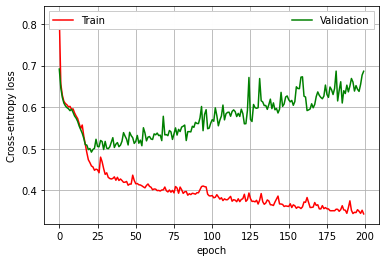

In [ ]:
x = list(range(len(train_losses)))
ax = plt.subplot(111)
plt.plot(x, train_losses, 'r', label="Train")
plt.plot(x, val_losses, 'g', label="Validation")
plt.xlabel('epoch')
plt.ylabel('Cross-entropy loss')
plt.grid()
leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=False, fancybox=False)
leg.get_frame().set_alpha(0.99)

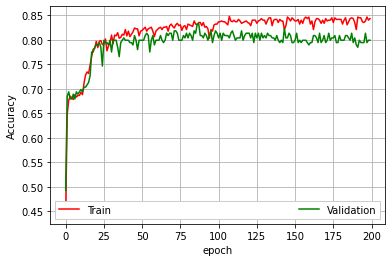

In [ ]:
x = list(range(len(train_accuracies)))
ax = plt.subplot(111)
plt.plot(x, train_accuracies, 'r', label="Train")
plt.plot(x, val_accuracies, 'g', label="Validation")
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.grid()
leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=False, fancybox=False)
leg.get_frame().set_alpha(0.99)

### Exercise 6

*   What do you observe in the previous graphs?
*   At which epoch is it interesting to retrieve the model parameters for inference?

... # To complete.


## Evaluating the model

We can finally evaluate our model on our test dataset.

In [ ]:
test_loss, test_acc = evaluate(neural_net, test_loader, device)

Eval:  Avg_Loss: 0.52639   Acc: 160/209 (76.555%)


### Exercise 7

* Compare validation and test metrics.
* Do you think the chosen features are informative of the fate of the passenger?

... # To complete.


